# Non Parametric - KNN, Parzen 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
data = pd.read_excel('./weather_data.xlsx').values
print(type(data), data.shape)
print(data[:5,:])

<class 'numpy.ndarray'> (1000, 7)
[[  28   59   20 1008    0    0   20]
 [  48   61   10 1012    1    0   21]
 [  24   53    3 1001    0    0   16]
 [  17   54    8 1002    0    0   16]
 [  27   51    5 1007    0    0   14]]


In [25]:
train_data=data[:700,:]
TEST_data=data[700:,:]

Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(300, 6) (300, 1)


In [26]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

# KNN

In [27]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
k = no. of neighbours
metric - 0,1,2 norm : distance/metric between two vectors | 0 means infinite norm

output-
y_pred (n,)
'''
def Predict_using_KNN(train_data, X_test, k, metric):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1:]
    y_pred_test = np.zeros((X_test.shape[0],))
    for i in range(len(X_test)):
        x = X_test[i].reshape(1,-1)
        metrics = np.absolute(X_train-x)
        if metric==0:
            metrics = metrics.max(axis=1)
        elif metric==1:
            metrics = metrics.sum(axis=1)
        else: # metric=2
            metrics = np.sqrt(np.square(metrics).sum(axis=1))
        
        metrics_mapped_to_labels = np.column_stack((metrics,y_train))
        metrics_mapped_to_labels = metrics_mapped_to_labels[metrics_mapped_to_labels[:,0].argsort()]
        
        y_pred_test[i]=metrics_mapped_to_labels[:k,-1].mean()
        
    return y_pred_test

In [28]:
#cross validate
def cross_validate(Cross_Validation_data, k, metric):
    test_error_CV = []
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])

        y_pred_test = Predict_using_KNN(remaining_data_for_training, validation_data[:,:-1], k, metric)

        test_error_CV.append(mse_loss(validation_data[:,-1], y_pred_test))

    n_cv = len(test_error_CV)
    test_error = sum(test_error_CV)/n_cv
    return test_error

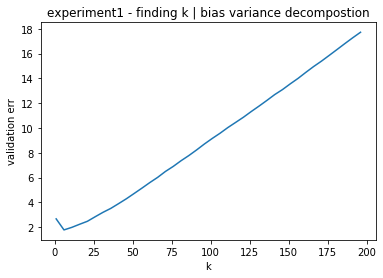

In [29]:
test_errs = []
ks=np.arange(1,200,5)
for k in ks:
    print('k=%u'%k,end='\r')
    _1 = cross_validate(Cross_Validation_data, k=k, metric=2)
    test_errs.append(_1)
plt.title('experiment1 - finding k | bias variance decompostion')
plt.plot(ks, test_errs)
plt.xlabel('k')
plt.ylabel('validation err')
plt.savefig('q2_knn.png')
plt.show()

In [30]:
val_err_KNN=test_errs

In [31]:
print("min val error k =",ks[test_errs.index(min(test_errs))])

min val error k = 6


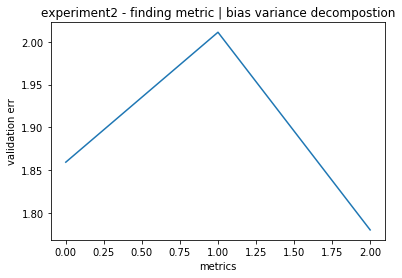

In [32]:
test_errs = []
norms=[0,1,2]
for norm in norms:
    print('norm=%u'%norm,end='\r')
    _1 = cross_validate(Cross_Validation_data, k=6, metric=norm)
    test_errs.append(_1)
plt.title('experiment2 - finding metric | bias variance decompostion')
plt.plot(norms, test_errs)
plt.xlabel('metrics')
plt.ylabel('validation err')
plt.show()

In [33]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
cross_val_acc = cross_validate(Cross_Validation_data, k=6, metric=2)
print("cross validation",cross_val_acc)

cross validation 1.7798015873015873


In [34]:
y_pred_TEST = Predict_using_KNN(train_data, TEST_data[:,:-1], k=6, metric=2)
print("TEST error",mse_loss(y_pred_TEST, TEST_data[:,-1]))

TEST error 2.2375925925925926


In [35]:
y_pred_TEST_KNN = y_pred_TEST

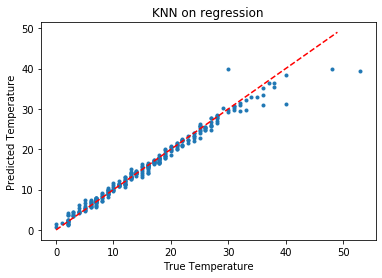

In [13]:
plt.title('KNN on regression')
plt.scatter(TEST_data[:,-1:], y_pred_TEST,label='True vs Predicted Temp.',marker='.')
a=np.arange(0,50,1)
plt.plot(a,a,label='y=x',color='r',linestyle='dashed')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.savefig('q2_knn2.png')
plt.show()

# Parzen Window

In [36]:
'''
input - 
train_data (n,d+1) - last col is y
X_test (n,d)
h = window size => x belongs in hypercube (of vol h^d) centered at x0 if np.max(np.absolute(x-xo))<=h/2

output-
y_pred (n,)
'''
def Predict_using_Parzen(train_data, X_test, h):
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    
    y_pred_test = np.zeros((X_test.shape[0],))
    for i in range(len(X_test)):
        x = X_test[i].reshape(1,-1)
        window_fn = np.max(np.absolute(X_train-x),axis=1) <= (h/2)
        y_pred_test[i] = y_train[window_fn].mean() if len(y_train[window_fn])!=0 else -1

    return y_pred_test

In [39]:
#cross validate
def cross_validate(Cross_Validation_data, h):
    test_error_CV = []
    for i,validation_data in enumerate(Cross_Validation_data):
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])

        y_pred_test = Predict_using_Parzen(remaining_data_for_training, validation_data[:,:-1], h)

        test_error_CV.append(mse_loss(validation_data[:,-1], y_pred_test))

    n_cv = len(test_error_CV)
    test_error = sum(test_error_CV)/n_cv
    return test_error

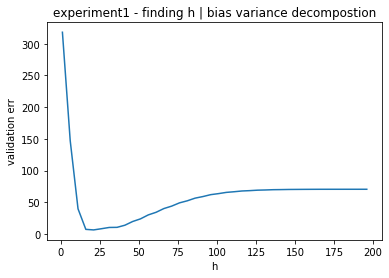

In [40]:
test_errs = []
hs=np.arange(1,200,5)
for h in hs:
    print('h=%u'%k,end='\r')
    _1 = cross_validate(Cross_Validation_data, h=h)
    test_errs.append(_1)
plt.title('experiment1 - finding h | bias variance decompostion')
plt.plot(hs, test_errs)
plt.xlabel('h')
plt.ylabel('validation err')
plt.savefig('q2_parzen1.png')
plt.show()

In [41]:
val_err_PARZEN = test_errs

In [42]:
print("min val error h =",hs[test_errs.index(min(test_errs))])

min val error h = 21


In [43]:
# FINALLY, give cross validation accuracy and complete TEST accuracy
cross_val_acc = cross_validate(Cross_Validation_data, h=21)
print("cross validation",cross_val_acc)

cross validation 6.429864316488702


In [44]:
y_pred_TEST = Predict_using_Parzen(train_data, TEST_data[:,:-1], h=21)
print("TEST error",mse_loss(y_pred_TEST, TEST_data[:,-1]))

TEST error 18.063550010471804


In [45]:
y_pred_TEST_Parzen = y_pred_TEST

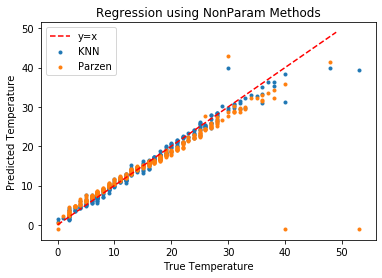

In [47]:
plt.title('Regression using NonParam Methods')
plt.scatter(TEST_data[:,-1:], y_pred_TEST_KNN,label='KNN',marker='.')
plt.scatter(TEST_data[:,-1:], y_pred_TEST_Parzen,label='Parzen',marker='.')
a=np.arange(0,50,1)
plt.plot(a,a,label='y=x',color='r',linestyle='dashed')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.savefig('q2_NonParam.png')
plt.legend()
plt.show()

the error is higher in PARZEN because if there is no point in the hypercube, h(x) = -1 : what else to predict :(

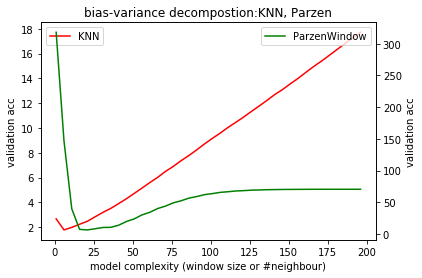

In [56]:
fig,ax = plt.subplots()
plt.title('bias-variance decompostion:KNN, Parzen')
x=np.arange(1,200,5)
ax.plot(x, val_err_KNN,label='KNN',c='r')
ax.set_xlabel("model complexity (window size or #neighbour)")
ax.set_ylabel('validation acc')
plt.legend()
ax2=ax.twinx()
ax2.plot(x, val_err_PARZEN,label='ParzenWindow',c='g')
ax2.set_ylabel('validation acc')
plt.legend()
fig.savefig('BiasVariance_KNNParzen.png')
plt.show()